In [ ]:
from logging import warning
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy.ma.core import size
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from scipy.stats.mstats import trim

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
tongkol = "https://docs.google.com/spreadsheets/d/1ZFY7E9F7TFotGQXeZ6fvFcn4aOoJBH1L/edit?usp=sharing&ouid=109777427362824163419&rtpof=true&sd=true".split("/")[-2]
tongkol = drive.CreateFile({'id':tongkol})
tongkol.GetContentFile('tongkol_jatim.xlsx')

In [ ]:
data = 'tongkol_jatim.xlsx'

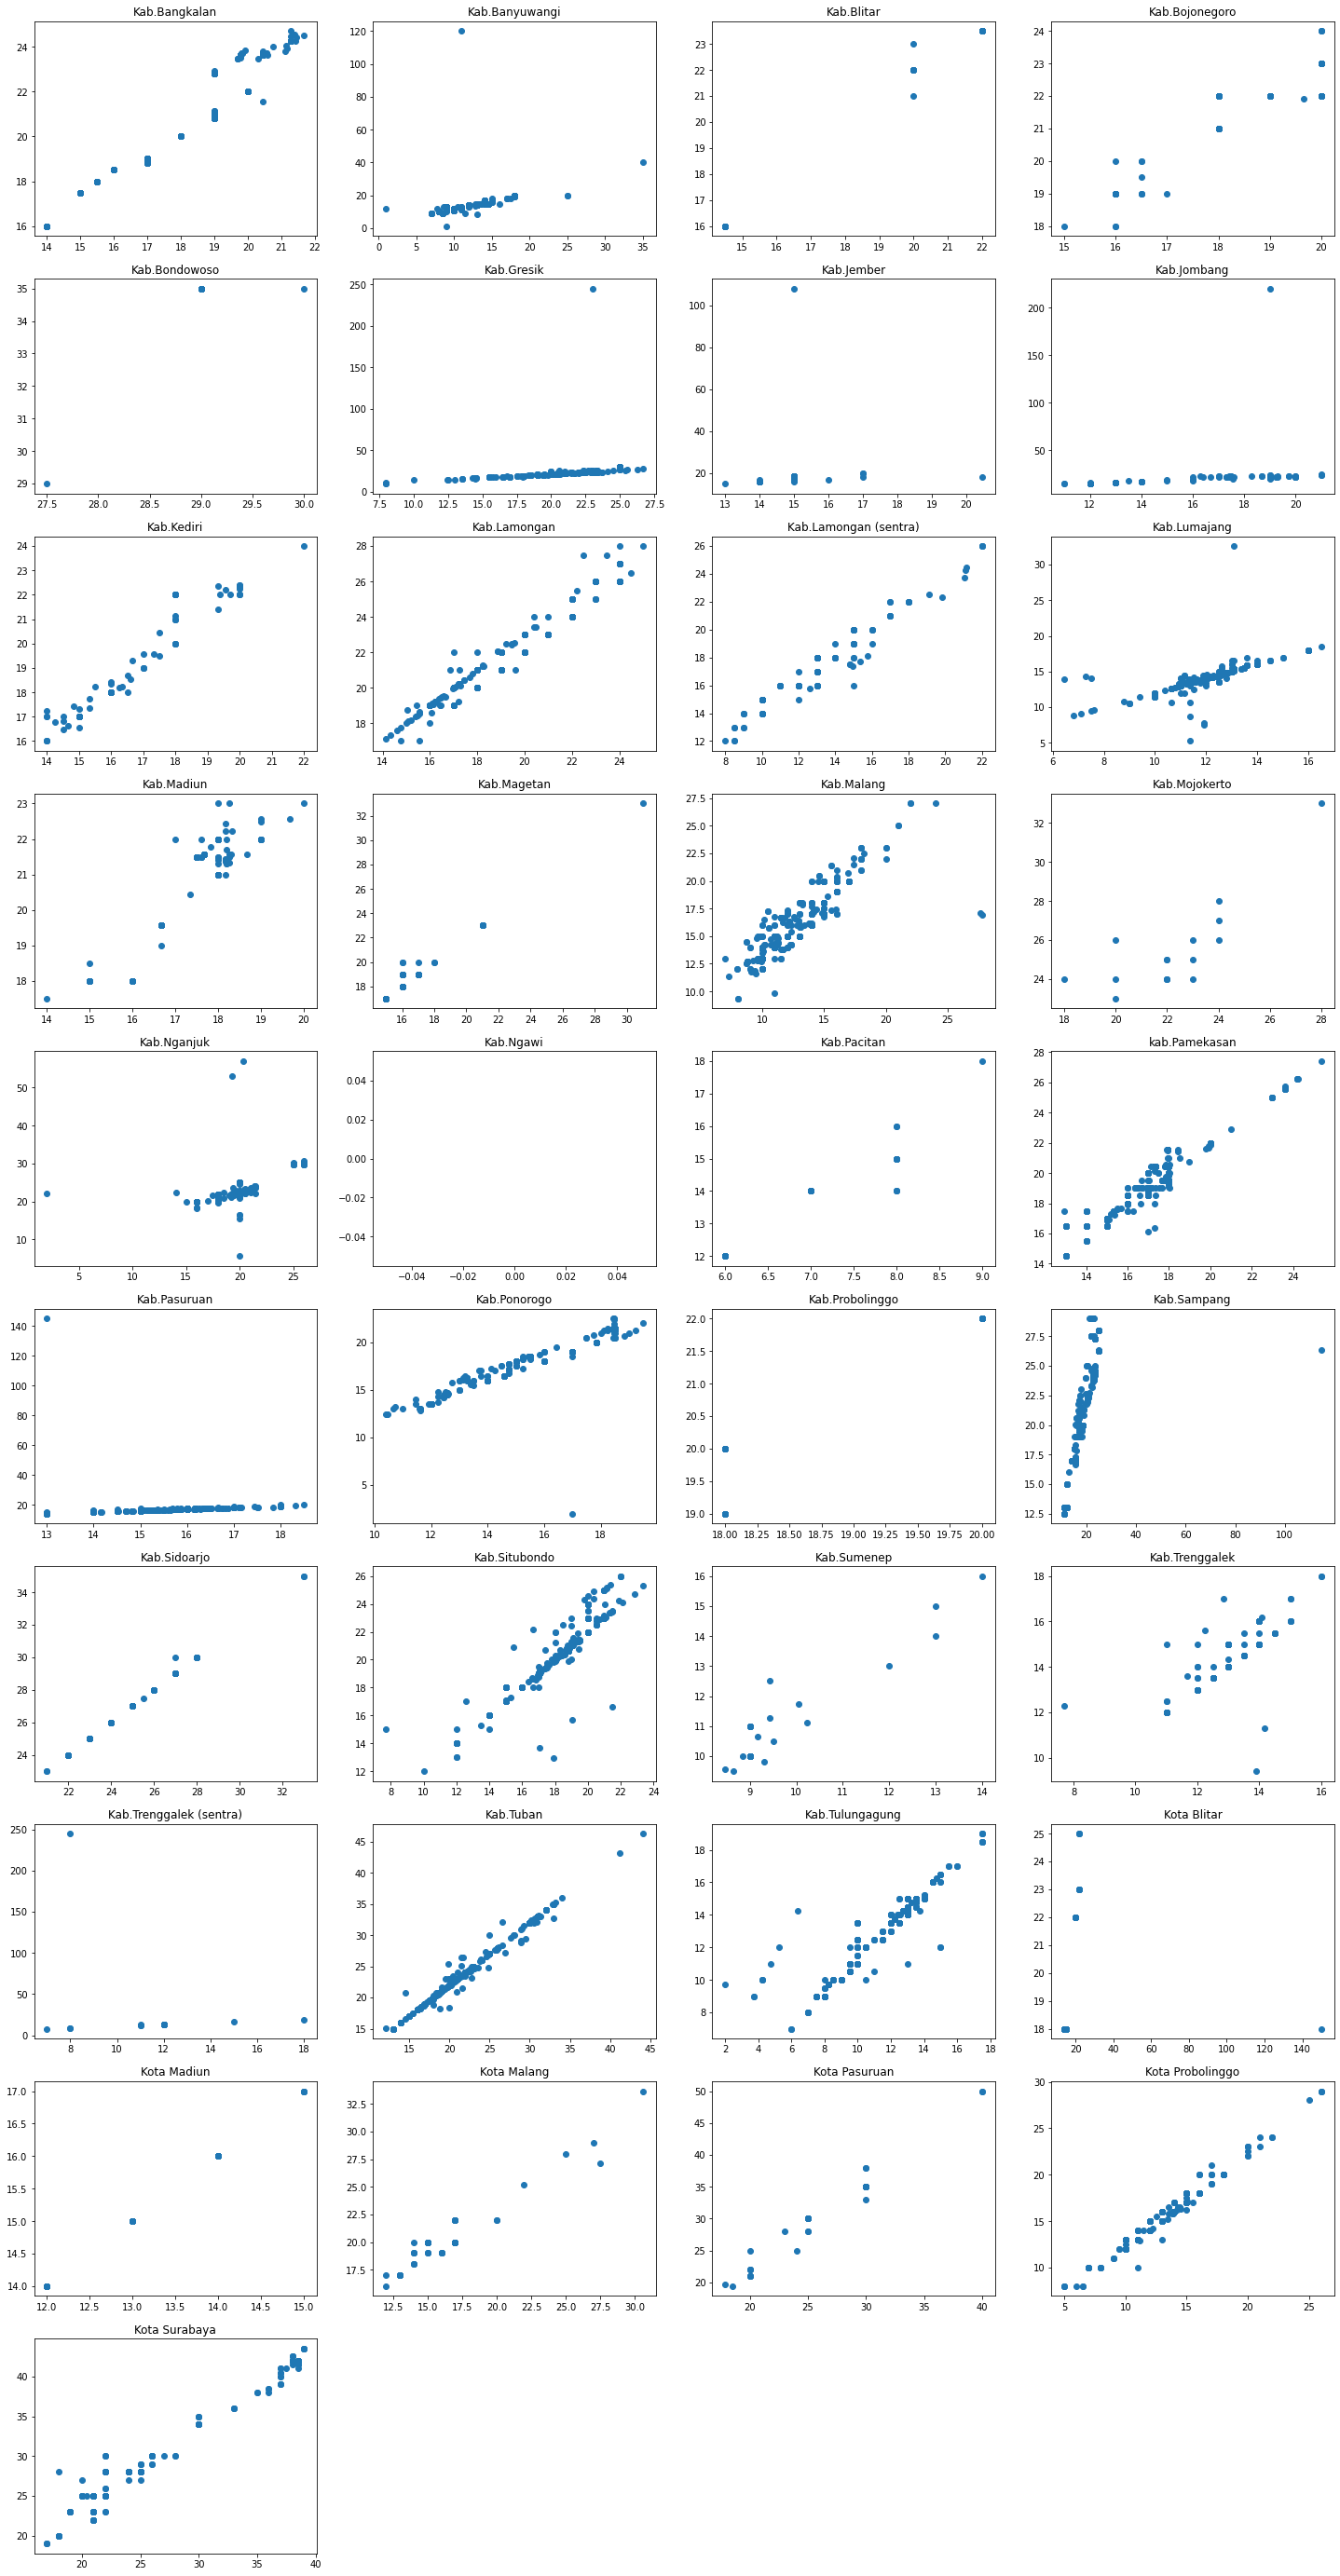

In [ ]:
main_file = pd.ExcelFile(data)
sheets = main_file.sheet_names
a = 0

plt.figure(figsize=(25, 50))
for sheet in sheets:
  a+=1
  df = pd.read_excel(data, sheet_name=sheet)
  plt.subplot(10, 4, a)
  plt.scatter(data=df, x="Harga_Produsen", y="Harga_Grosir")
  plt.title(df["Kabupaten"][0])
plt.show()

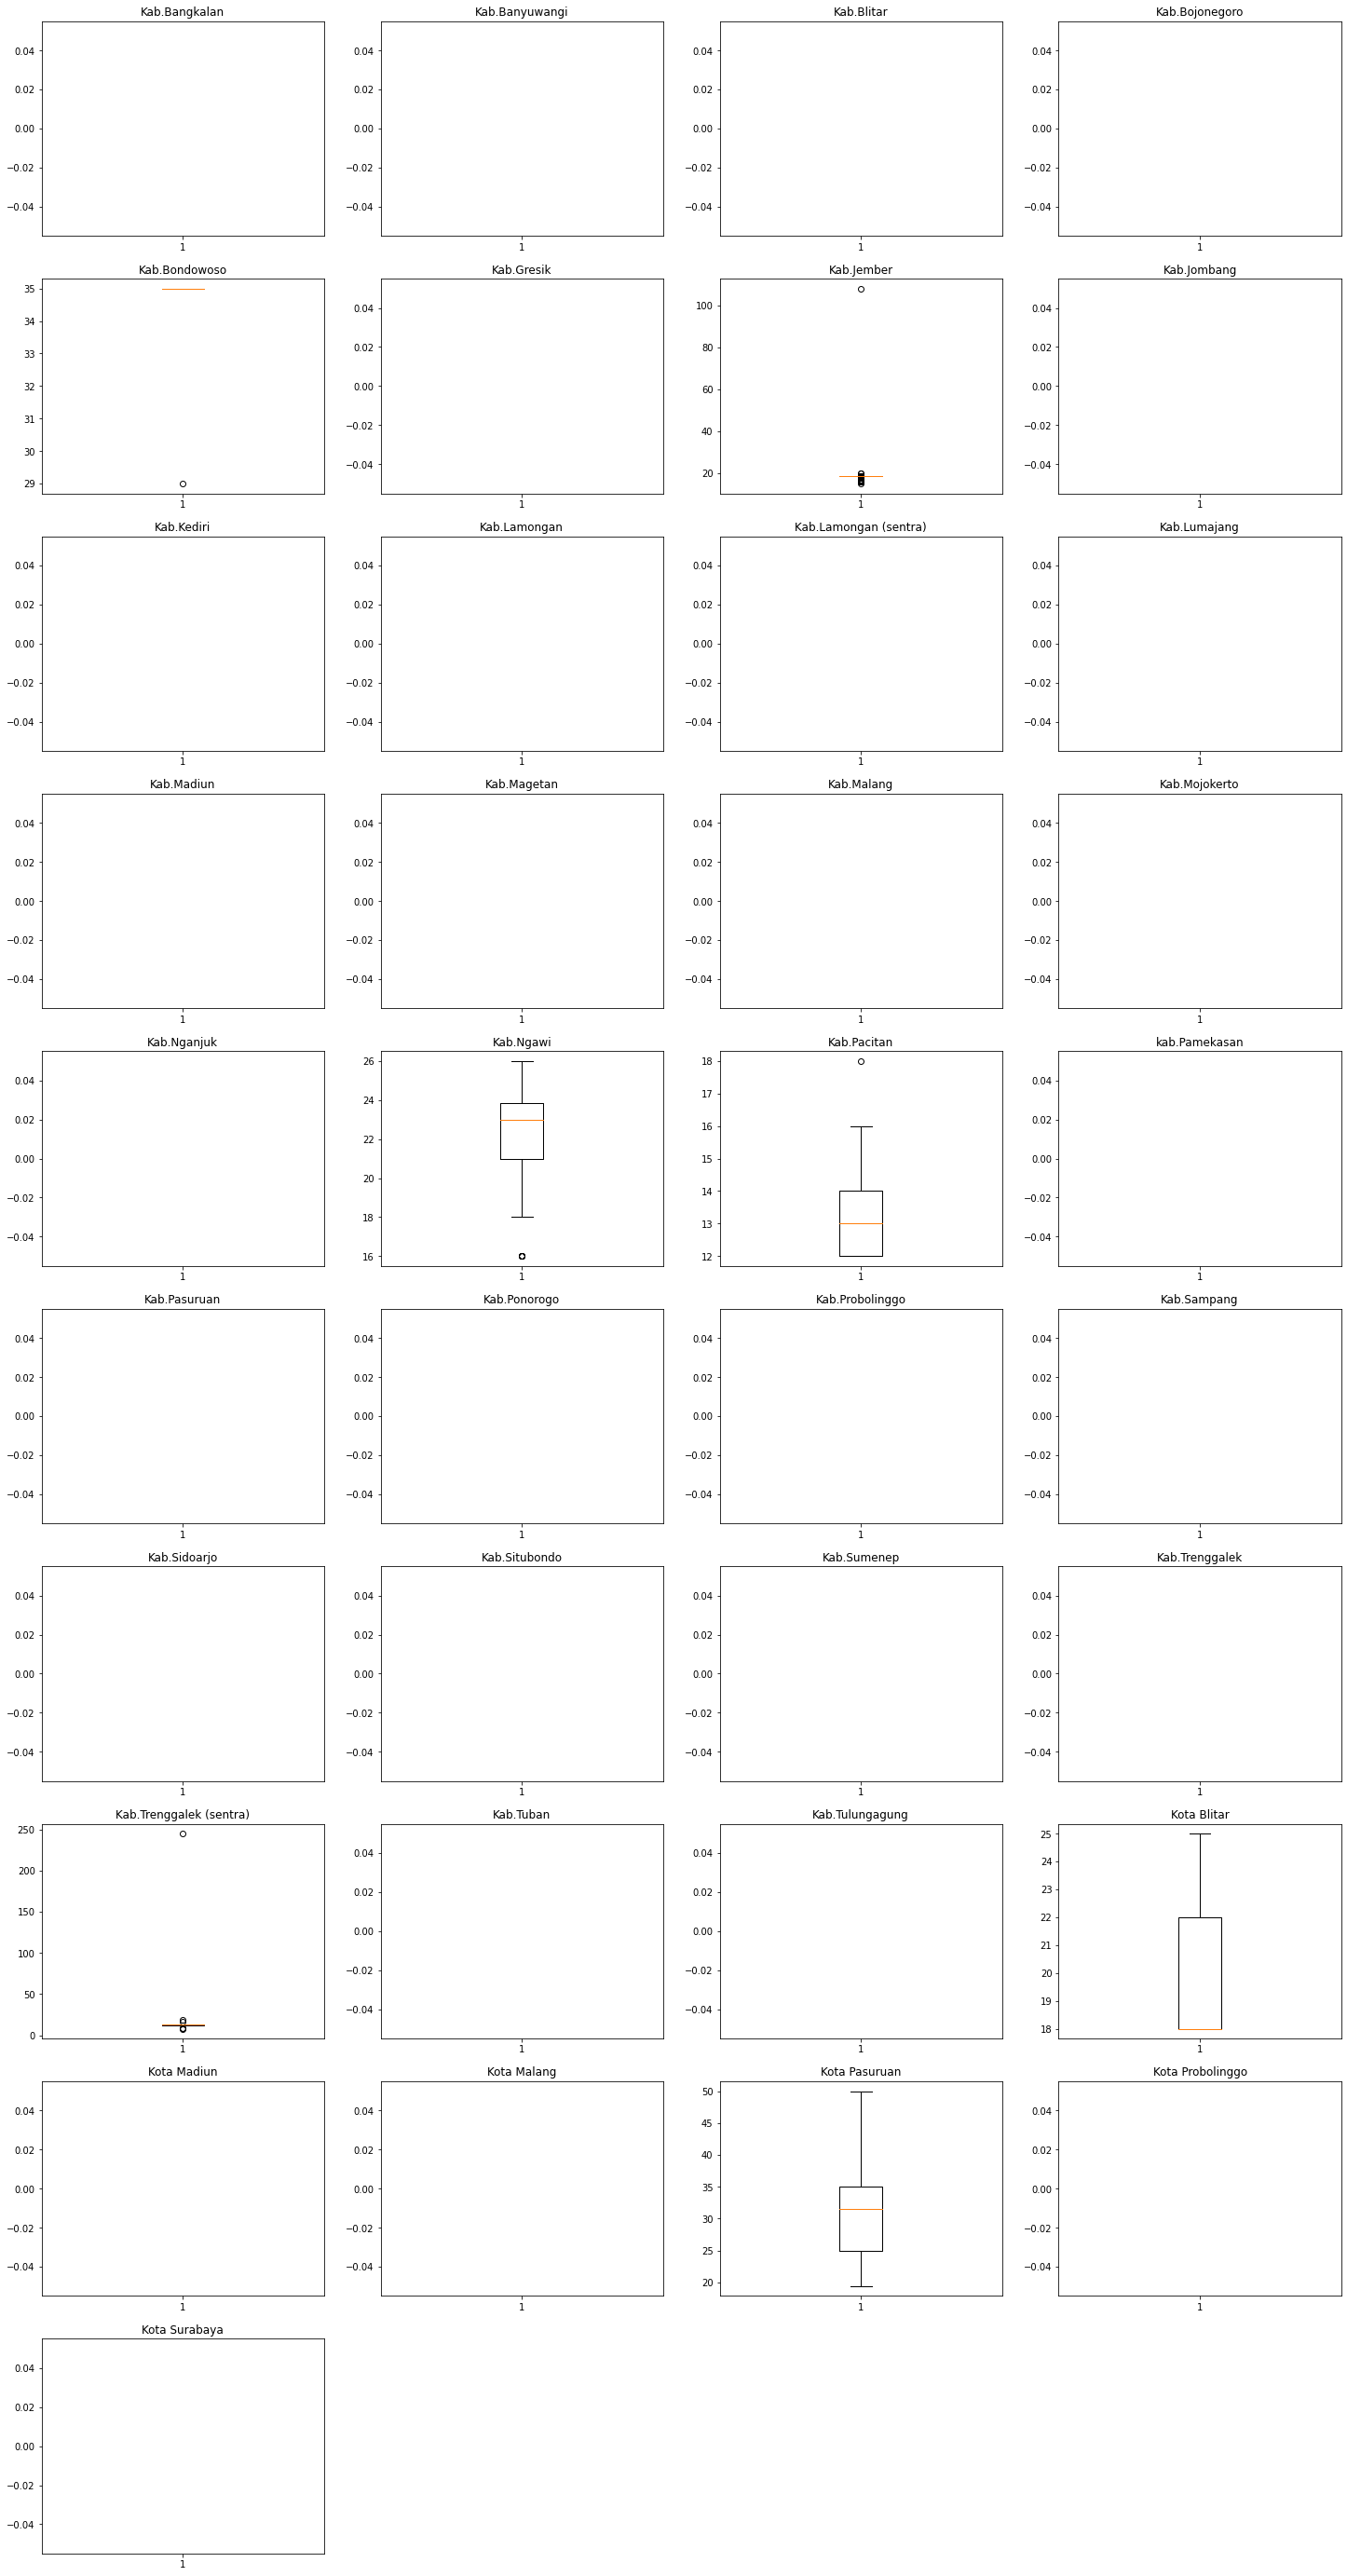

In [ ]:
main_file = pd.ExcelFile(data)
sheets = main_file.sheet_names
a = 0

plt.figure(figsize=(25, 50))
for sheet in sheets:
  a+=1
  df = pd.read_excel(data, sheet_name=sheet)
  plt.subplot(10, 4, a)
  plt.boxplot(data=df, x="Harga_Grosir")
  plt.title(df["Kabupaten"][0])
plt.show()

In [ ]:
! rm -r 'perkab' 'saved_model'

In [ ]:
! mkdir 'perkab'

In [ ]:
data = 'tongkol_jatim.xlsx'

for sheet in sheets:
  df = pd.read_excel(data, sheet_name=sheet)
  column = ["Harga_Produsen", "Harga_Grosir", "Harga_Eceran"]

  for i in column:
    df[i] = df[i].astype(float)
  
  for i in column :
    df[i] = df[i].map(lambda x:x*1000)

  df.dropna(axis=0, inplace=True)
  if int(sheet) == 17:
    continue

  scaler = StandardScaler()
  MinMax = MinMaxScaler(feature_range=(0, 1))
  
  df["Harga_Produsen"] = scaler.fit_transform(df["Harga_Produsen"].values.reshape(-1, 1))
  df["Harga_Grosir"] = scaler.fit_transform(df["Harga_Grosir"].values.reshape(-1, 1))

  df["Harga_Produsen"] = MinMax.fit_transform(df["Harga_Produsen"].values.reshape(-1, 1))
  df["Harga_Grosir"] = MinMax.fit_transform(df["Harga_Grosir"].values.reshape(-1, 1))

  df.dropna(axis=0, inplace=True)

  df.to_excel(f'perkab/{sheet}.xlsx', index=False)

# Data Understanding

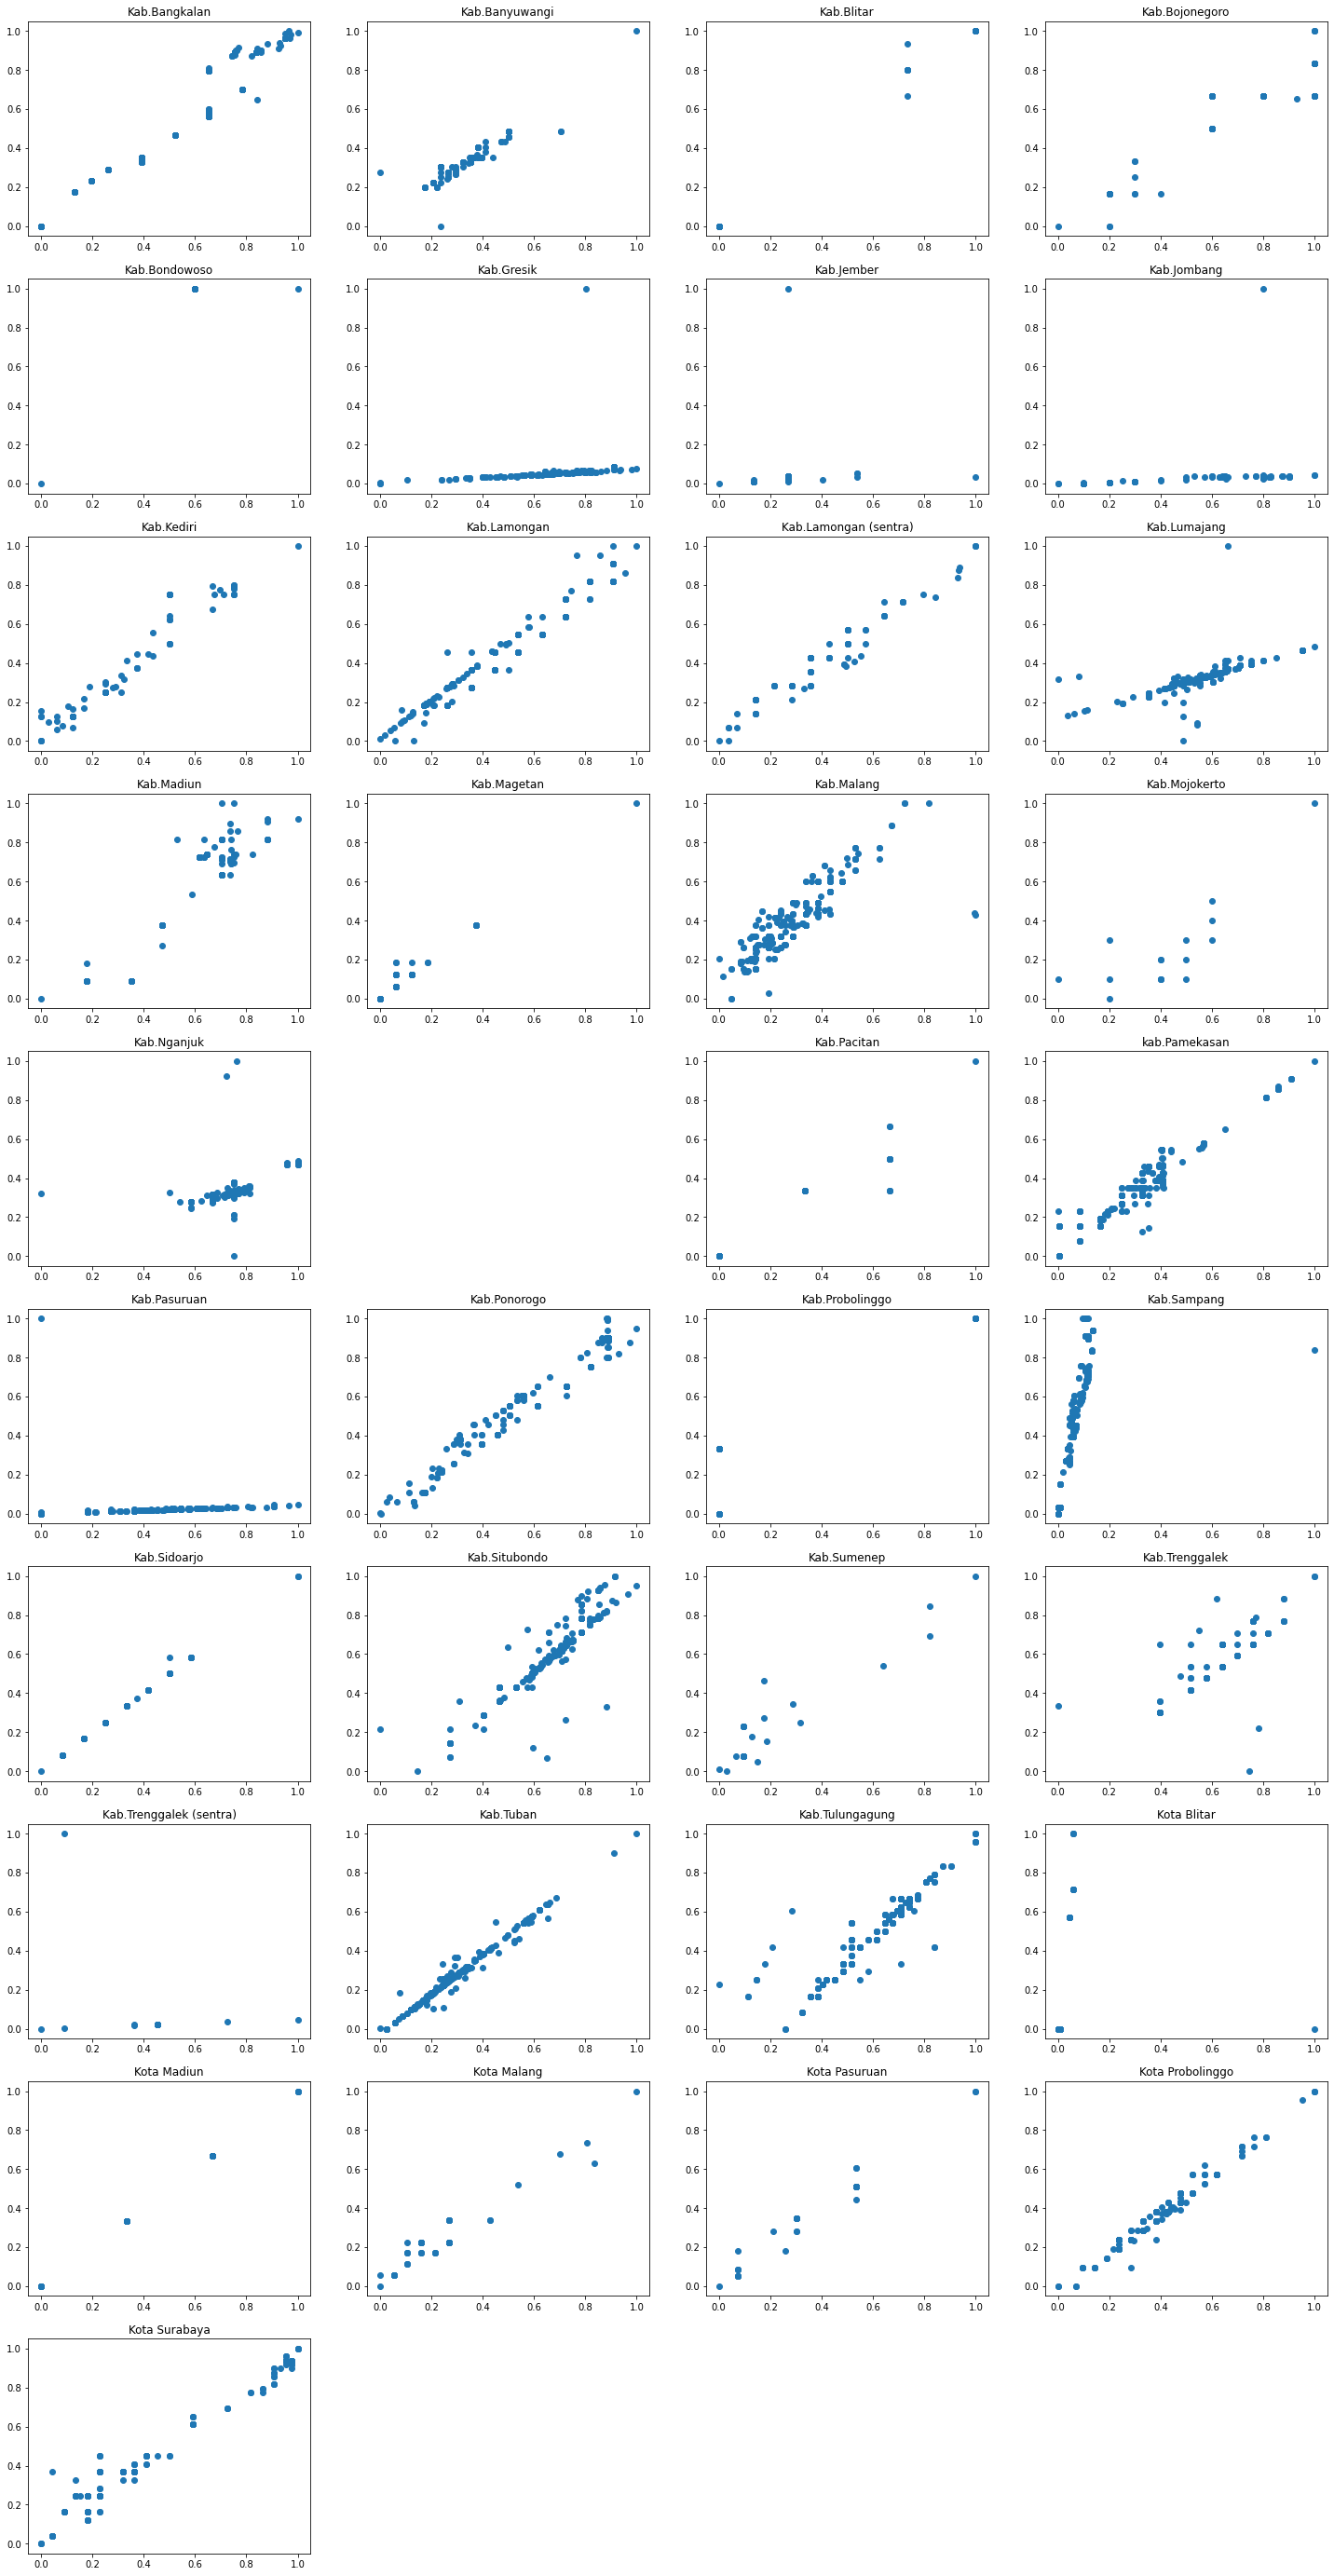

In [ ]:
files_perkab = [os.path.splitext(filename)[0] for filename in os.listdir('perkab')]

plt.figure(figsize=(25, 50))
for i in files_perkab:
  test_data = pd.read_excel(f'perkab/{i}.xlsx')
  if test_data["Kabupaten"].count() != 0:
    plt.subplot(10, 4, int(i)+1)
    plt.scatter(data=test_data, x="Harga_Produsen", y="Harga_Grosir")
    plt.title(test_data["Kabupaten"][0])
plt.show()

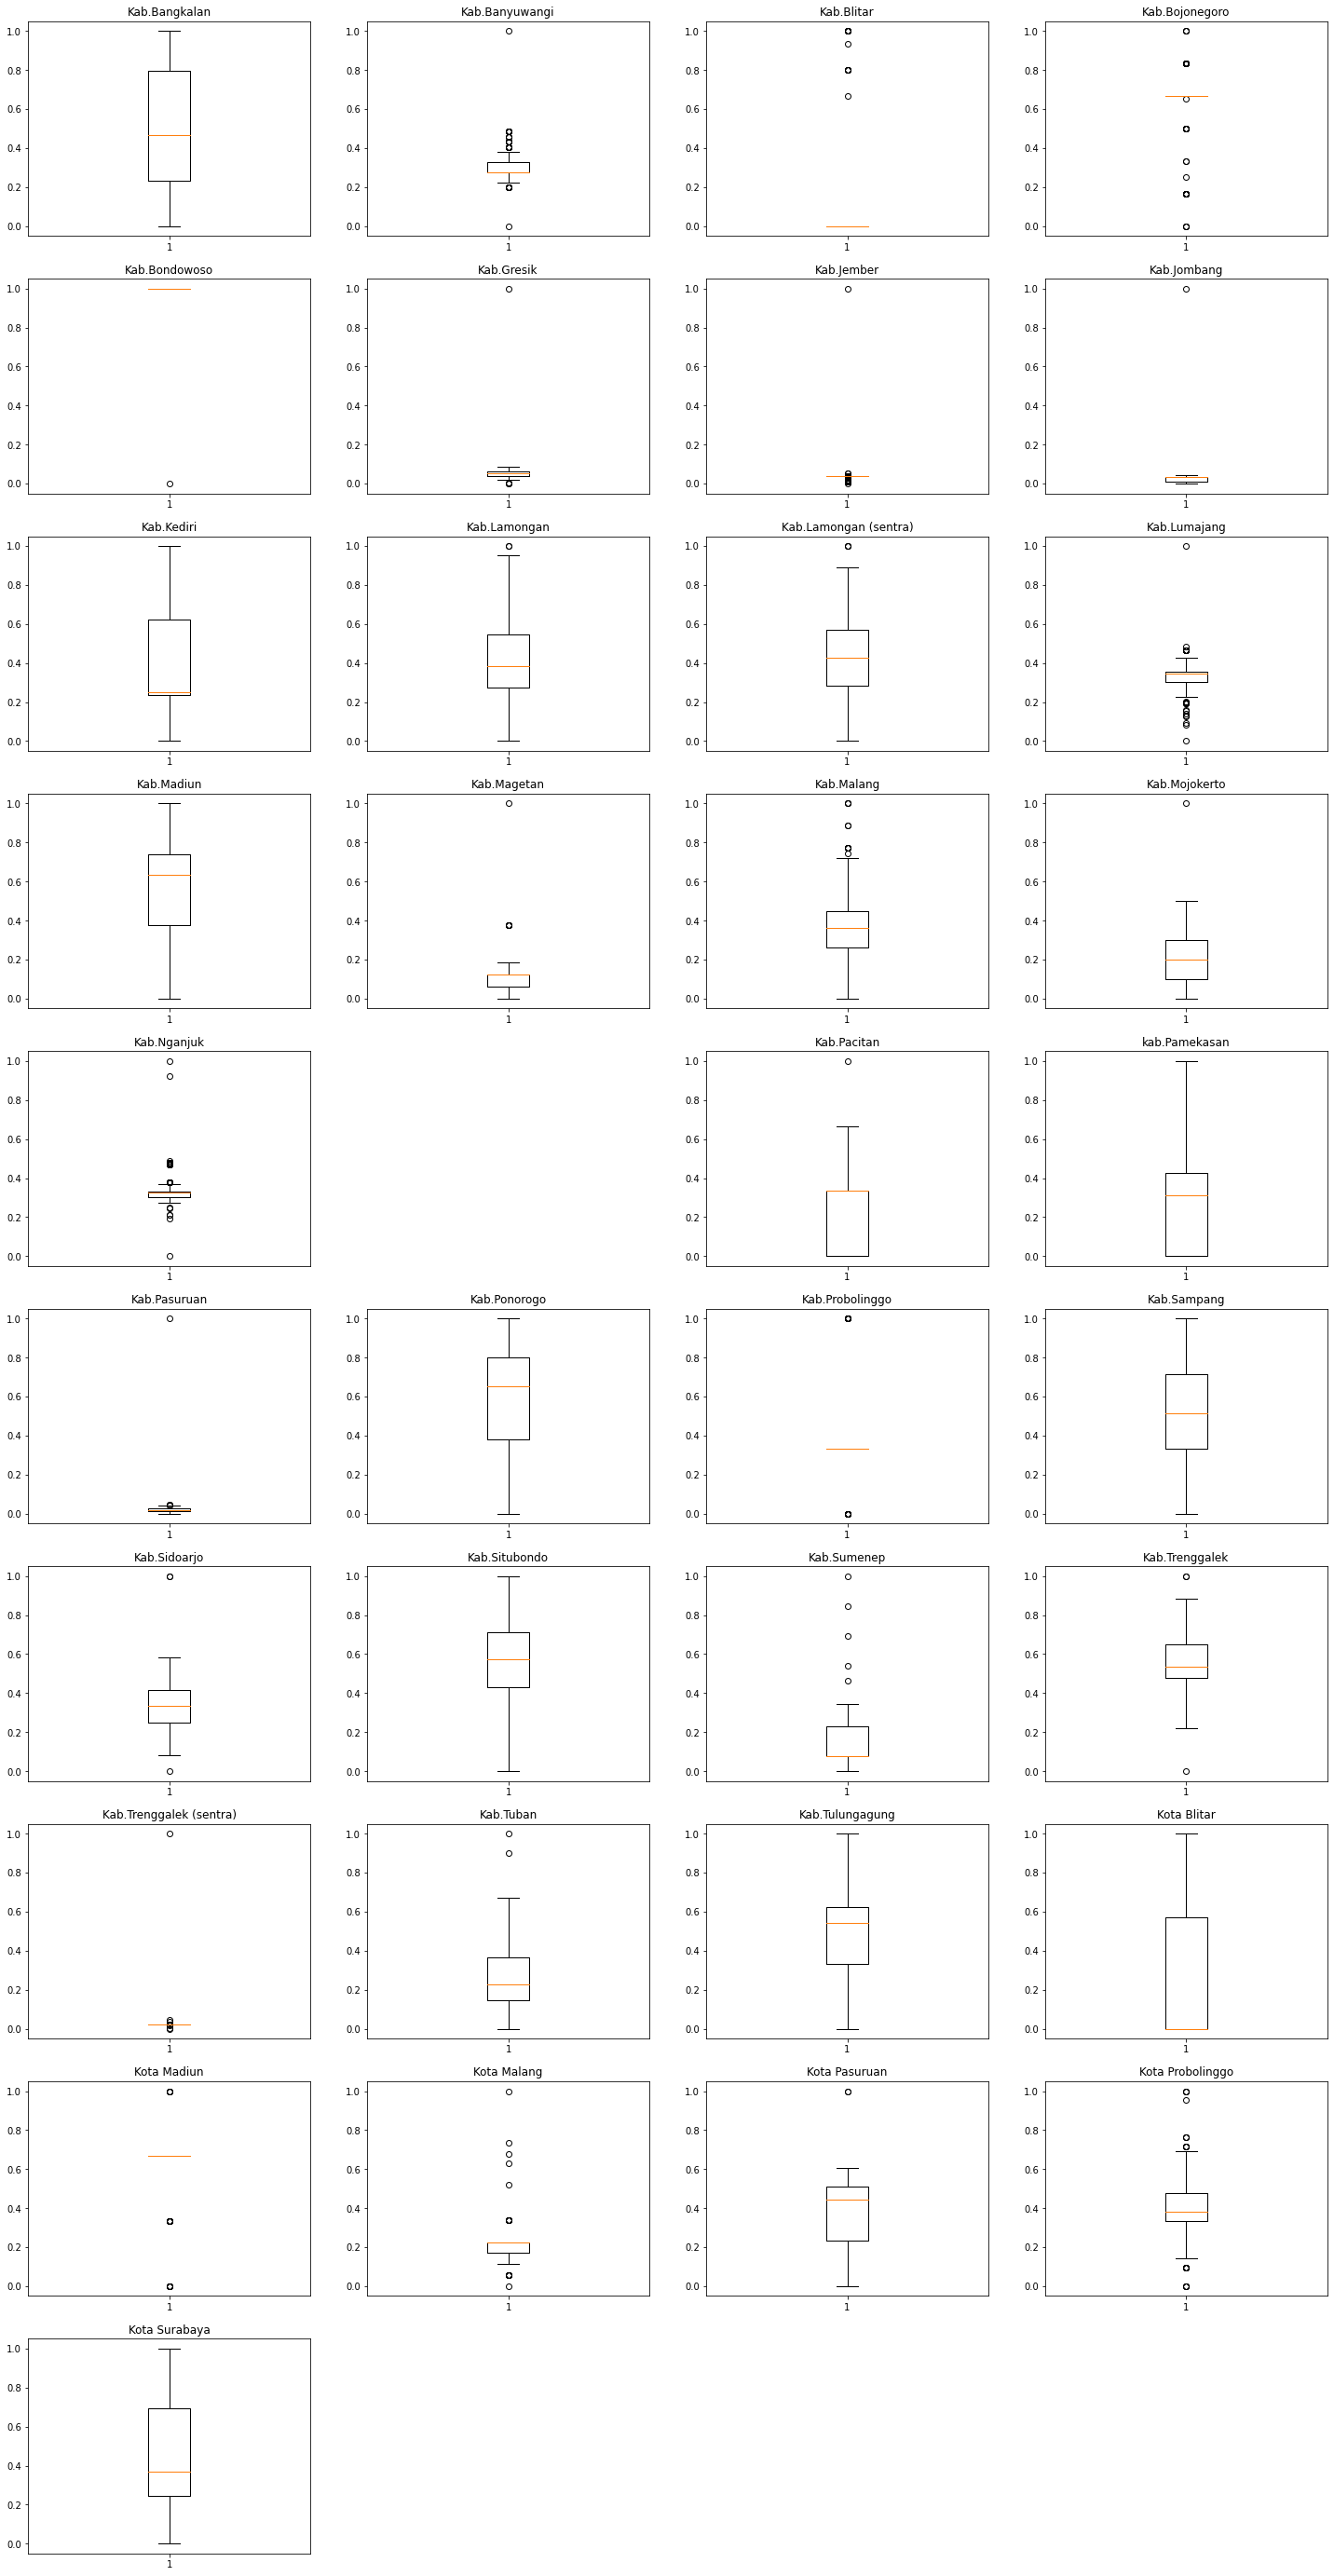

In [ ]:
files_perkab = [os.path.splitext(filename)[0] for filename in os.listdir('perkab')]

plt.figure(figsize=(25, 50))
for i in files_perkab:
  test_data = pd.read_excel(f'perkab/{i}.xlsx')
  if test_data["Kabupaten"].count() != 0:
    plt.subplot(10, 4, int(i)+1)
    plt.boxplot(data=test_data, x="Harga_Grosir")
    plt.title(test_data["Kabupaten"][0])
plt.show()

In [ ]:
for i in range(37):
  if i == 17:
    continue
  test_data = pd.read_excel(f'perkab/{i}.xlsx')
  korelasi = test_data[["Harga_Produsen", "Harga_Grosir"]].corr()["Harga_Produsen"]["Harga_Grosir"]
  if korelasi > 0.95:
    print(test_data["Kabupaten"][0]+" : "+str(korelasi))

Kab.Bangkalan : 0.956051883407796
Kab.Blitar : 1.0
Kab.Lamongan : 0.9509011174829984
Kab.Pacitan : 0.9557694890292587
kab.Pamekasan : 0.9618661908234123
Kab.Pasuruan : 0.9637948076614202
Kab.Ponorogo : 0.9711789279497188
Kab.Sampang : 0.9525434542331005
Kab.Sidoarjo : 1.0000000000000007
Kab.Trenggalek (sentra) : 0.9794515009954231
Kab.Tuban : 0.9890104337615285
Kota Blitar : 0.9930529613584143
Kota Madiun : 1.0000000000000002
Kota Pasuruan : 0.966976021720405
Kota Probolinggo : 0.9685951204460274
Kota Surabaya : 0.9742025572799891


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import MeanSquaredError as MSE
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError as MAE
from tensorflow.keras.models import load_model

In [ ]:
model = Sequential()
model.add(Dense(1, input_dim=1))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss=MSE(), optimizer='adam', metrics=['mean_squared_error'])

In [ ]:
! mkdir 'saved_model'

In [ ]:
for i in range(37) :

  if i == 17:
    continue

  data = pd.read_excel(f'perkab/{i}.xlsx')
  korelasi = data[["Harga_Produsen", "Harga_Grosir"]].corr()["Harga_Produsen"]["Harga_Grosir"]
  kab = data["Kabupaten"][0].replace('.', '_')
  kab = kab.replace(' ', '_')

  if korelasi > 0.95:
    X = data["Harga_Produsen"].to_numpy()
    y = data["Harga_Grosir"].to_numpy()
    y = y.reshape(-1, 1)

    print(kab)
    history = model.fit(X, y, epochs=25 , batch_size=1)
  
    if min(history.history['mean_squared_error']) < 1:
      history.model.save(f'saved_model/{kab}.h5')

Kab_Bangkalan
Epoch 1/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 2/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 3/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 4/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 5/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 6/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 7/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 8/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 9/25
395/395 [==============================] - 1s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0

In [ ]:
! mkdir

In [ ]:
models = [os.path.splitext(filename)[0] for filename in os.listdir('saved_model')]
for i in models:
  model = load_model(f'saved_model/{i}.h5')
  hasil = int(model.predict([25000]))
  lokasi = i.replace('_', '.')
  print(f'{lokasi} : {hasil+4000}')

Kab.Lamongan : 28451
Kab.Lamongan.(sentra) : 27057
Kab.Sidoarjo : 28884
Kab.Blitar : 29629
Kota.Probolinggo : 29328
Kota.Malang : 25301
Kab.Pacitan : 23157
Kab.Magetan : 28477
Kab.Ponorogo : 28264
kab.Pamekasan : 30703
Kab.Bangkalan : 29434
Kota.Madiun : 29000
Kab.Kediri : 30819
Kota.Pasuruan : 27819
Kota.Surabaya : 26904
Kab.Tuban : 29920


In [ ]:
import shutil
from google.colab import files

shutil.make_archive("model_harga_ikan", 'zip', "saved_model")
files.download(f'model_harga_ikan.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>